<div>
    <img src="https://static.tacdn.com/img2/brand_refresh/Tripadvisor_lockup_horizontal_secondary_registered.svg" width="300"/>
</div>

# Predict TripAdvisor Rating

## В этом соревновании нам предстоит предсказать рейтинг ресторана 

# Информация по признакам:
* City [city]: Город 
* Cuisine Style [cuisine_style]: Кухня
* Ranking [ranking]: Ранг ресторана относительно других ресторанов в этом городе
* Price Range [price_range]: Цены в ресторане в 3 категориях
* Number of Reviews [number_of_reviews]: Количество отзывов
* Reviews [reviews]: 2 последних отзыва и даты этих отзывов
* URL_TA [url_ta]: страница ресторана на 'www.tripadvisor.com' 
* ID_TA [id_ta]: ID ресторана в TripAdvisor
* Rating [rating]: Рейтинг ресторана (Целевая переменная)

# imports

In [1]:
!pip install textblob

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from textblob import TextBlob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast # can convert stringify arrays to list
import regex as re
from datetime import datetime

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
kaggle/input/sf-dst-restaurant-rating/main_task.csv
kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [3]:
# Установим не ограниченную ширину для датасетов
pd.set_option('display.max_columns', None)

In [4]:
# Фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы.
RANDOM_SEED = 42

# Текущая дата
CURRENT_DATE = pd.to_datetime('08/02/2021')

# Путь до датасетов.
MAIN_DIR = './kaggle/input/sf-dst-restaurant-rating/'

In [5]:
# Фиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Функции помошники

In [6]:
def draw_heatmap(df, size=(15,10)):
    plt.rcParams['figure.figsize'] = size
    sns.heatmap(df.corr(), cmap="RdBu", annot=True)


def draw_hist(df, column, bins=100, size=(15,10), kde=False):
    '''
    Draws histogra
    
    Parameters:
    df (pandas.DataFrame): Data set.
    kde (bool, optional): Whether to plot a gaussian kernel density estimate.
    bins (int, optional): Specification of hist bins.
    size (tuple, optional): Size of the chart
    '''
    plt.rcParams['figure.figsize'] = size
    sns.distplot(df[column], bins=bins, kde=kde)


def draw_boxplot(df, x, y, rotation=0, size=(15,10)):
    plt.rcParams['figure.figsize'] = size
    sns.boxplot(x=x, y=y, data=df)
    plt.xticks(rotation=rotation)


def draw_clasterization(x_column, y_column, df, size=(15,10)):
    plt.rcParams['figure.figsize'] = size
    sns.lmplot(x=x_column, y=y_column, data=df)


def boxplot_x(series):
    '''
    The function draws boxplot for particular series

    Parameters:
    series (pandas.Series)
    '''

    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(x=series, color='yellow', ax=ax)
    plt.xticks(rotation=45)
    plt.show()

In [7]:
def show_df_info(df):
    name_len = len(df.name)
    total_len = 46
    points_len = int((total_len - name_len - 2)/2)

    print(f"{'-'*points_len} {df.name} {'-'*points_len}")
    print(df.info(verbose=True))


def populate_none_values(df, column, new_vals):
    '''
    The function populates None values.

    Parameters:
    df (DataFrame).
    column (str): A name of a column.
    new_vals(Series or one common value): The new values for all None values.
    '''

    df.loc[df[column].isna(), column] = new_vals


def get_statistical_borders(df, column):
    '''
    The function calculates statistical borders. The values beyond the borders are garbage.

    Parameters:
    column (str): A name of a column.

    Returns:
    (float32, float32): Returns statistical borders from-to.
    '''

    perc25 = df[column].quantile(q=0.25, interpolation='midpoint')
    perc75 = df[column].quantile(q=0.75, interpolation='midpoint')
    IQR = perc75 - perc25

    take_from = perc25 - 1.5*IQR
    take_to = perc75 + 1.5*IQR

    return take_from, take_to



def transform_stringified_array_to_array(df, column):
    df.loc[~df[column].isna(), column] = df.loc[
        ~df[column].isna(), 
        column
    ].apply(lambda x: ast.literal_eval(x))


def normalization(x, x_min, x_max):
    return (x-x_min)/(x_max-x_min)


def get_min_max_normalization(df, column):
    x_min, x_max = df[column].agg(['min', 'max'])
    return normalization(df[column], x_min, x_max)


def get_dummies(df, column, df_name):
    df = pd.get_dummies(df, columns=[column], dummy_na=True)
    df.name = df_name
    return df


def count_reviews(reviews):
    return len(reviews[0])


def get_price_range_type(price_type_str, price_ranges_dict):
    return np.uint8(price_ranges_dict.get(price_type_str, 0))


def normalize_name(name_str):
    return name_str.lower().replace(' ', '_')


def get_cuisine_name(cuisine_name_str):
    cuisine = normalize_name(cuisine_name_str)
    return f'cuisine_{cuisine}'


def get_most_common_cuisines(df, count=15):
    cuisines_counter = Counter()

    for cuisines in df.loc[~df['cuisine_style'].isna(), 'cuisine_style']:
        for cuisine in cuisines:
            if cuisine != 'other':
                cuisines_counter[cuisine] += 1

    return cuisines_counter.most_common(count)


def recount_nan_number_of_reviews(df):
    populate_none_values(
        df,
        'number_of_reviews',
        df.loc[df['number_of_reviews'].isna() ,'reviews'].apply(count_reviews)
    )


def process_cuisine_style(df, cuisines):        
    df[get_cuisine_name('other')] = np.uint8(0)

    for cuisine in cuisines:
        df[get_cuisine_name(cuisine)] = np.uint8(0)

    for i, row in df.iterrows():
        for cuisine in row['cuisine_style']:
            if cuisine in cuisines:
                df.at[i, get_cuisine_name(cuisine)] = np.uint8(1)
            else:
                df.at[i, get_cuisine_name('other')] = np.uint8(1)


def min_max_normalization_for_ranking_in_city(df, city):
    ranking_for_city = df['ranking'][df['city'] == city]
    x_min = ranking_for_city.min()
    x_max = ranking_for_city.max()
    return normalization(ranking_for_city, x_min, x_max)


def min_max_normalization_for_ranking_in_cities(df):
    for city in df['city'].unique():
        df.loc[df['city'] == city, 'ranking_by_city'] = min_max_normalization_for_ranking_in_city(df, city)


def clean_review(review): 
    ''' 
    Utility function to clean review text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", review).split())


def get_review_sentiment(review): 
    ''' 
    Utility function to classify sentiment of passed review using textblob's sentiment method 
    '''
    analysis = TextBlob(clean_review(review)) 

    return analysis.sentiment.polarity


def round_of_rating(number):
    '''
    Округляем до 0.5
    '''
    
    return np.round(number * 2) / 2

# Классы для работы с датасетами

In [8]:
class TripAdvisorRepository():
    def __init__(self, main_dir):
        self.__load_data(main_dir)
    
    def __load_dataframe(self, path, df_name):
        df = pd.read_csv(path)
        df.name = df_name
        return df

    def __concat_dataframes(self, dfs, new_df_name):
        data = dfs[0]

        for i in range(1, len(dfs)):
            data = data.append(dfs[i], sort=False).reset_index(drop=True)

        data.name = new_df_name
        return data
    
    def __rename_columns(self, dfs):
        for df in dfs:
            columns = dict(df.columns.map(lambda x: (x, x.lower().replace(' ', '_'))))
            df.rename(columns=columns, inplace=True)
    
    def __load_data(self, main_dir):
        self.__df_train = self.__load_dataframe(main_dir + 'main_task.csv', 'df_train')
        self.__df_test = self.__load_dataframe(main_dir + 'kaggle_task.csv', 'df_test')
        self.__sample_submission = self.__load_dataframe(main_dir + 'sample_submission.csv', 'sample_submission')       
        
        self.__rename_columns([self.__df_train, self.__df_test])
        
        # ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
        self.__df_train['sample'] = 1 # помечаем где у нас трейн
        self.__df_test['sample'] = 0 # помечаем где у нас тест
        self.__df_test['rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
        
        self.__data = self.__concat_dataframes([self.__df_test, self.__df_train], 'data')
        
        # Отобразим основную информацию по датасетам
        show_df_info(self.__data)
    
    def update_data(self, df):
        self.__data = df

    @property
    def df_county(self):
        return self.__df_county
    
    @property
    def df_city_population(self):
        self.__df_city_population
    
    @property
    def data(self):
        return self.__data
    
    @property
    def df_train(self):
        return self.__df_train
    
    @property
    def df_test(self):
        return self.__df_test
    
    @property
    def sample_submission(self):
        return self.__sample_submission

# DATA

In [9]:
repository = TripAdvisorRepository(MAIN_DIR)

-------------------- data --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB
None


# Cleaning and Preparing Data

## 1. Осмотра данных и первичные преобразования

### Restaurant ID [restaurant_id]

In [10]:
repository.data['restaurant_id'].sample(3)

38334    id_1907
24454    id_2460
47209    id_1339
Name: restaurant_id, dtype: object

In [11]:
# Уберем `id_` чтобы преобразовать признак в числовой тип
repository.data['restaurant_id'] = repository.data['restaurant_id'].apply(lambda x: x[3:]).astype('uint16')

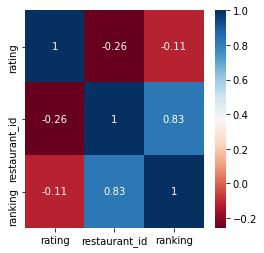

In [12]:
draw_heatmap(repository.data[['rating', 'restaurant_id', 'ranking']], (4, 4))

**restaurant_id**  сильно зависит от **ranking**. Переменная является ID ресторана и для обучения модели будет безполезной. Пока оставим ее, возможно она пригодиться для создания новых признаков далее.

In [13]:
# Проверим уникальность значений
sum(repository.data['restaurant_id'].value_counts() > 1)

9287

Данный признак часто дублибруется. Посморим подробнее.

In [14]:
repository.data['restaurant_id'].value_counts()

436      19
871      19
633      19
227      19
430      18
         ..
14784     1
6898      1
9597      1
15742     1
9140      1
Name: restaurant_id, Length: 13094, dtype: int64

In [15]:
repository.data[repository.data['restaurant_id'] == 436].head(3)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
436,436,Lisbon,"['European', 'Portuguese']",2904.0,NaN,2.0,"[[], []]",/Restaurant_Review-g189158-d5003144-Reviews-Gu...,d5003144,0,0.0
12955,436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613,1,4.5
14674,436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362,1,4.0


Признаков с названиями у нас нет. Один и тот же это ресторан или нет, пока ответить мы не можем. Города разные, возможно это сеть ретсоранов. Далее посморим на признак `url_ta` и `id_ta`. Возможно он даст больше информации. 

### City [city]

Этот признак не содержит пропусков. Рассмотрим его подробнее.

In [16]:
# Посмотрим какие города есть и сколько в них ресторанов
repository.data['city'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

In [17]:
# Количество уникальных городов
len(repository.data['city'].unique())

31

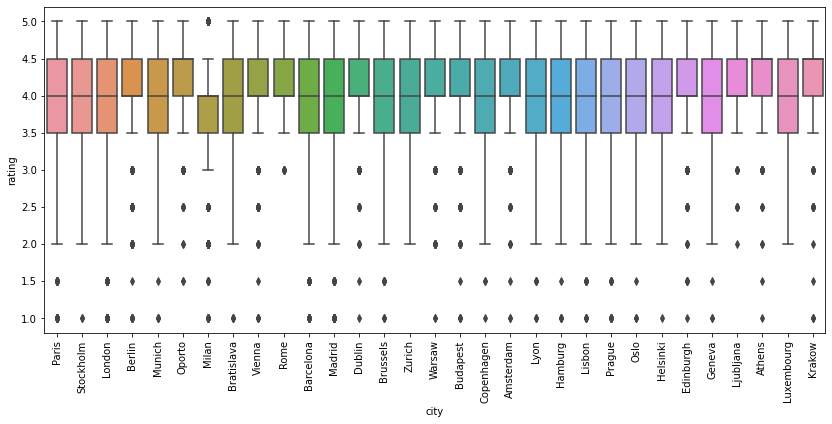

In [18]:
draw_boxplot(repository.df_train, 'city', 'rating', rotation=90, size=(14,6))

На графике можно увидеть, что рейтинг ресторанов в Rome начинаются с 3, а в Milan вероятность рейтинга с оценкой 5 очень мала.

Из этого признака можно будет сделать категориальный, создав dummy переменную. Сделаем это позднее, он может пригодиться для создания новых признаков.

### Number of Reviews [number_of_reviews]

Признак является числовым. Посмотрим подробнее.

In [19]:
# Посмотрим на количество пропусков
repository.data['number_of_reviews'].isnull().sum()

3200

В датасете так же есть переменная **reviews**. Возможно мы сможем достать данные из нее для **number_of_reviews** после исследования. Пока же добавим новый признак говорящий о том, содерж(ит/ла) ли строка пустое значение.

In [20]:
repository.data['number_of_reviews_is_nan'] = np.uint8(0)
repository.data.loc[repository.data['number_of_reviews'].isna(), 'number_of_reviews_is_nan'] = np.uint8(1)

### Reviews [reviews]

Переменная сожержит всего два пропуска. Мы можем заполнить их необходимым типом данных. А далее вернуться к **number_of_reviews**. Для начала посмотрим какие данные в нем храняться.

In [21]:
# Количество пропусков
repository.data['reviews'].isna().sum()

2

In [22]:
repository.data['reviews'].head(5)

0                                             [[], []]
1    [['Very good reviews!', 'Fine dining in Hakani...
2    [['Better than the Links', 'Ivy Black'], ['12/...
3    [['Most exquisite', 'Delicious and authentic']...
4    [['Always the best in bratislava', 'Very good ...
Name: reviews, dtype: object

In [23]:
# Посмотрим на тип данных
type(repository.data.iloc(0)[0]['reviews'])

str

В этом признаки содержаться двумерные массивы сохраненные как строки. Судя по всему, в первом храняться два последних отзыва (информация есть в описании к датасету), а второй содержит даты отзывов. Заполним пустые значения двумя пустыми массивами. Далее приобразуем строки в массивы.

In [24]:
populate_none_values(repository.data, 'reviews', '[[], []]')

In [25]:
def parse_str_arr(arr_str):
    try:
        ast.literal_eval(arr_str)
    except:
        print(arr_str)

In [26]:
# попробуем преобразовать и посмотреть получится ли. Если нет, то посмотрем какие данные не прошли
repository.data['reviews'].apply(parse_str_arr)

[['Will certainly be back', nan], ['11/26/2017', '07/27/2017']]
[[nan, 'Good food with decent service'], ['11/21/2017', '07/21/2017']]


0        None
1        None
2        None
3        None
4        None
         ... 
49995    None
49996    None
49997    None
49998    None
49999    None
Name: reviews, Length: 50000, dtype: object

Итак, преобразование строк в массивы упало в двух местах из-за встречающихся nan в массиваз с сообщениями. Преобразуем строки в массивы и обработаем данную особенность.

In [27]:
# Обработаем nan значения в массивах сообщений
repository.data['reviews'] = repository.data['reviews'].apply(lambda x: x.replace("[nan", "[''").replace("nan]", "'']"))

In [28]:
# Преобразование строк в массивы
transform_stringified_array_to_array(repository.data, 'reviews')

Теперь когда у нас все `reviews` заполнены, можно попробовать заполнить **number_of_reviews** основываясь на **reviews**. Но для начала проверим, какое количество отзывов в массивах в тех строках, где **number_of_reviews** равен  `nan`.

In [29]:
# Посмотрим какое количество отзывов мы получили: min-max
repository.data.loc[repository.data['number_of_reviews'].isna(), 'reviews'].apply(lambda x: len(x[0])).unique()

array([0, 1])

Отлично. Можем заполнять **number_of_reviews** основываясь на **reviews**

In [30]:
# Основываясь на признаке reviews заполним number_of_reviews
recount_nan_number_of_reviews(repository.data)

Попробуем посмотреть на выбросы

In [31]:
get_statistical_borders(repository.data, 'number_of_reviews')

(-140.0, 252.0)

Проверим сколько таких ресторанов где отзывов больше 252.

In [32]:
sum(repository.data['number_of_reviews'] > 252)

5946

/Users/eldarkalachev/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


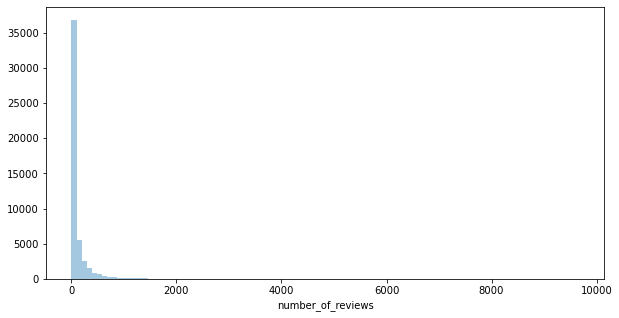

In [33]:
draw_hist(repository.data, 'number_of_reviews', bins=100, size=(10,5))

Если смотреть на выбросы, то у нас получилось почти 6К значение. Очень много. Гистограмма показала смещение вправо. После 1000-1300 значение сильно уменьшается. Попробуем посмотреть сколько таких значений.

In [34]:
sum(repository.data['number_of_reviews'] > 1300)

480

In [35]:
# Заменим значения более 1300 на 1300.
repository.data['number_of_reviews'] = repository.data['number_of_reviews'].apply(lambda x: x if x < 1300 else 1300)

In [36]:
repository.data['number_of_reviews'].describe()

count    50000.000000
mean       108.461420
std        209.813872
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       1300.000000
Name: number_of_reviews, dtype: float64

### Price range [price_range]

Данный признак сожержит много пропусков. Посмотрим на содержимое.

In [37]:
repository.data['price_range'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

In [38]:
repository.data['price_range'].isna().sum()

17361

Создадим признак говорящий что строка содержила `nan` значение. Далее приобразуем строковый признак в числовой основываясь на данных. `$ = 1, $$ - $$$ = 2, $$$$ = 3`.

In [39]:
repository.data['price_range_is_nan'] = np.uint8(0)
repository.data.loc[repository.data['price_range'].isna(), 'price_range_is_nan'] = np.uint8(1)

In [40]:
# Приобразуем строковые данные в числовые
price_range_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
repository.data['price_range'] = repository.data['price_range'].map(price_range_dict)

In [41]:
# Пока заполним пустоту нулем, а далее посмотрим.
repository.data['price_range'].fillna(0, inplace=True)

In [42]:
repository.data['price_range'].value_counts()

2.0    23041
0.0    17361
1.0     7816
3.0     1782
Name: price_range, dtype: int64

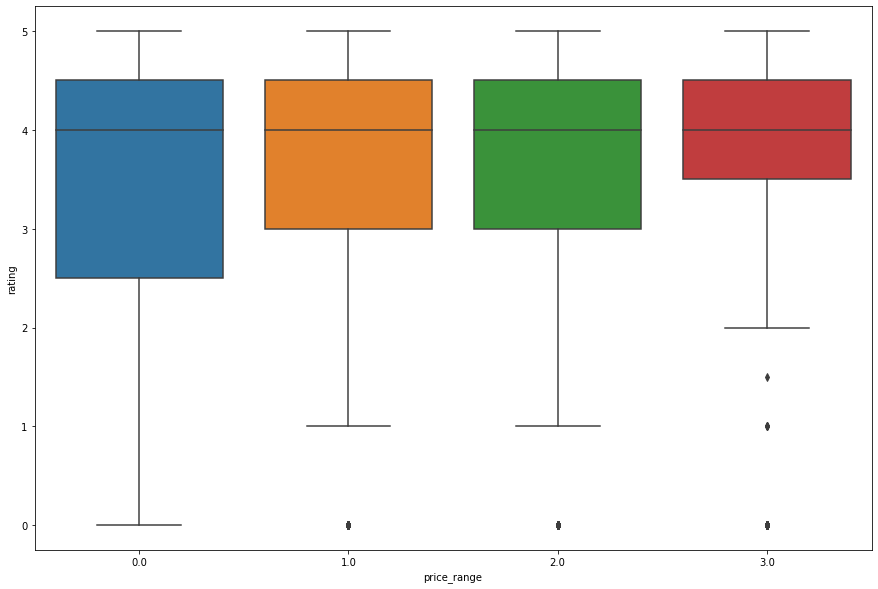

In [43]:
draw_boxplot(repository.data, x='price_range', y='rating')

Дорогие рестораны реже всего получают плохие оценки

### ID_TA [id_ta]

In [44]:
# Посмотрим значения признака
repository.data['id_ta'].sample(5)

22437    d1340145
33152    d1057662
30713     d800023
46294     d720385
22650    d4915058
Name: id_ta, dtype: object

In [45]:
# Проверим количество уникальных значений.
repository.data['id_ta'].nunique()

49963

In [46]:
# Есть ли рестораны с одинаковыми признаками этого типа.
sum(repository.data['id_ta'].value_counts() > 1)

37

Посмотрим пару ресторанов с одинаковым `id_ta`

In [47]:
repository.data['id_ta'].value_counts()

d11999956    2
d10316215    2
d1235635     2
d7342803     2
d11674463    2
            ..
d6434212     1
d12510765    1
d2620130     1
d1035406     1
d3510573     1
Name: id_ta, Length: 49963, dtype: int64

In [48]:
repository.data[repository.data['id_ta'] == 'd1315077']

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,number_of_reviews_is_nan,price_range_is_nan
20439,468,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",469.0,2.0,355.0,"[[Very good all around, Our first Madrid resta...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077,1,4.0,0,0
35785,511,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",512.0,2.0,355.0,"[[Very good all around, Our first Madrid resta...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077,1,4.0,0,0


Ранее мы рассматривали `restaurant_id` с большим количеством повторений. Прямой взаимосвязи между большим количеством одинаковых `restaurant_id` и `id_ta` нет. Судя по рассмотренным данным выше, у нас есть **37** ресторанов которые просто продублированны. Удалять дубликаты по заданию нам нельзя. Оставим все как есть, далее просто удалим признак `id_ta`.

### URL_TA [url_ta]

In [49]:
# Сделаем отображение информации в колонках шире для рассмотрения `url_ta`
pd.set_option('max_colwidth', 100)
repository.data[['restaurant_id', 'city', 'url_ta', 'id_ta']].head(5)

,restaurant_id,city,url_ta,id_ta
0,0,Paris,/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html,d10746918
1,1,Helsinki,/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html,d6674944
2,2,Edinburgh,/Restaurant_Review-g186525-d13129638-Reviews-Black_Ivy-Edinburgh_Scotland.html,d13129638
3,3,London,/Restaurant_Review-g186338-d680417-Reviews-Quirinale-London_England.html,d680417
4,4,Bratislava,/Restaurant_Review-g274924-d1112354-Reviews-Massimo_Ristorante-Bratislava_Bratislava_Region.html,d1112354


Итак, мы видим что `url_ta` содержит в себе `id_ta`, город, страну, название ресторана. А так же переменную g___. Так как парсить данные из сети нельзя, данный признак судя по всему будет безполезен далее. Но по названию ресторана, мы можем проверить версию сети ресторанов основываясь на `restaurant_id` и названии ресторана. Проверим. 

In [50]:
repository.data['restaurant_id'].value_counts()

436      19
871      19
633      19
227      19
430      18
         ..
14784     1
6898      1
9597      1
15742     1
9140      1
Name: restaurant_id, Length: 13094, dtype: int64

In [51]:
repository.data.loc[repository.data['restaurant_id'] == 227, ['id_ta', 'city', 'url_ta']].apply(
    lambda x: re.findall(f"{x['id_ta']}-Reviews-(.*?)-{x['city']}", x["url_ta"]), axis=1
)

227                               [Puerta_del_Sol]
11065                                  [Kicheneck]
14727                                    [Mercado]
16237                               [Olive_Garden]
17521                              [Feta_na_Freta]
19299                     [Proeflokaal_A_van_Wees]
22537                               [Casa_Alberto]
23876                                      [Goose]
24990    [Pinocchio_Italian_Restaurant_Temple_Bar]
27610                                [Kratochwill]
30591                                   [Sen_Chay]
32548                        [Lofthus_samvirkelag]
38763                      [Restaurante_Filigrana]
38846                            [Spiler_Original]
41368                                 [Lovster_Co]
42016                            [Gasthaus_Elsner]
48462                       [Umami_by_Michel_Roth]
49288                                    [Lumiere]
49601                                           []
dtype: object

После проверки нескольких дублирующихся `restaurant_id` ясно что это скорее всего не единая сеть. После проверки 5ти разных `restaurant_id` с повторяющимися значениями, ни одного одинакового названия не выявлено.

### Cuisine Style [cuisine_style]

Признак содержит много пропусков, добавим признак: **cuisine_style_is_nan**

In [52]:
repository.data['cuisine_style_is_nan'] = np.uint8(0)
repository.data.loc[repository.data['cuisine_style'].isna(), 'cuisine_style_is_nan'] = np.uint8(1)

In [53]:
repository.data['cuisine_style'].sample(5)

27845                                                                               NaN
35995                                                             ['Japanese', 'Sushi']
5785            ['Italian', 'Pizza', 'Seafood', 'Mediterranean', 'Vegetarian Friendly']
116      ['Bar', 'British', 'Pub', 'International', 'Gastropub', 'Vegetarian Friendly']
21777                                                                       ['Italian']
Name: cuisine_style, dtype: object

Данный столбец имеет пустые значения и тип его содержимого это массив приведенный к строке. В Nan значения пока запишем одно блюдо которое назовем как `['other']` и преобразуем строки в массивы.

In [54]:
# Заполнение Nan значений
repository.data['cuisine_style'].fillna('[]', inplace=True)

In [55]:
# Преобразование строк в массивы
transform_stringified_array_to_array(repository.data, 'cuisine_style')

In [56]:
show_df_info(repository.data)

-------------------- data --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   restaurant_id             50000 non-null  uint16 
 1   city                      50000 non-null  object 
 2   cuisine_style             50000 non-null  object 
 3   ranking                   50000 non-null  float64
 4   price_range               50000 non-null  float64
 5   number_of_reviews         50000 non-null  float64
 6   reviews                   50000 non-null  object 
 7   url_ta                    50000 non-null  object 
 8   id_ta                     50000 non-null  object 
 9   sample                    50000 non-null  int64  
 10  rating                    50000 non-null  float64
 11  number_of_reviews_is_nan  50000 non-null  uint8  
 12  price_range_is_nan        50000 non-null  uint8  
 13  cuisine_style_

Посмотрим на данные после первичной обработки. Пустых значений нет, все столбыцы приведены в удобную для дальнейшего нанали форму.

## 2. Feature Engineering
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [57]:
repository.data.drop(columns=['cuisine_style', 'reviews']).nunique(dropna=False)

restaurant_id               13094
city                           31
ranking                     12975
price_range                     4
number_of_reviews            1171
url_ta                      49963
id_ta                       49963
sample                          2
rating                         10
number_of_reviews_is_nan        2
price_range_is_nan              2
cuisine_style_is_nan            2
dtype: int64

Какие признаки можно считать категориальными?

Мы видим что под категориальный признак пока подходит только **city**. Со столбцом **cuisine_style** поработаем позже, так как в этом столбце хранятся массивы с типами кухонь.

### City [city]

Данная колонка не содержит пропусков. Города удобнее еспользовать как категориальный признак. Как мы выяснили выше, всего 31 город в датасете. Перед запуском обучения модели, приведем данный признак к dummy переменной. Пока оставим как есть для удобства оценки остальных признаков.

### Ранг по городам [ranked_cities]

In [58]:
repository.data['ranked_cities'] = repository.data['city'].rank()

### Cuisine Style [cuisine_style]

Данный признак так же является категориальным. Он хранится массивами для каждого ресторана. Nan значения в нем мы уже обработали. Прежден чем привести этот признак к dummy переменным, выделим 10-15 самых популярных кухонь и создадем новый признак говорящий о ресторане: готовят ли они самыю популярную кухню или нет. Перед обучением модели приведем этот признак к dummy переменным.

In [59]:
# Создадим новый признак для ресторана для хранения в нем количества популярных кухонь города в ресторана
repository.data['most_popular_cuisines_count'] = np.uint16(0)

In [60]:
def get_cuisines(city_cuisines):
    counter = Counter()
    for rest_cuisines in city_cuisines:
        for cuisine in rest_cuisines:
            counter[cuisine] += 1
    return counter

In [61]:
cuisines_in_city = dict(
    repository.data.groupby(by='city').apply(
        lambda x: get_cuisines(x['cuisine_style'])
    )
)

In [62]:
# Создадим временную переменную для хранения самой популярной кухни города
repository.data['most_popular_cuisine_in_city'] = repository.data['city'].apply(
    lambda x: cuisines_in_city[x].most_common(1)[0][0]
)

In [63]:
# Заполним NaN значения для cuisine_style самой популярной кухней в городе
repository.data['cuisine_style'] = repository.data.apply(
    lambda x: x['cuisine_style'] if x['cuisine_style_is_nan'] == 0 else [x['most_popular_cuisine_in_city']],
    axis=1
)

In [64]:
# Создадам новый признак говорящий сколько самых популярных кухонь города в ресторане
repository.data['number_of_most_popular_cuisines'] = np.uint8(0)

In [65]:
def get_number_most_popular_cuisines(row):
    popular_cuisines = cuisines_in_city[row['city']]
    counter = 0
    for cuisine in row['cuisine_style']:
        if cuisine in popular_cuisines:
            counter += 1
    return counter

In [66]:
repository.data['number_of_most_popular_cuisines'] = repository.data.apply(
    get_number_most_popular_cuisines, axis=1
)

### Reviews [reviews]
Как мы увидили, в отзывах помимо самих отзывов есть еще и даты двух последних отзывов. Что можно из этого извлечь:
- Мы можем посмотреть промежуток между последними двумя отзывами. Для этого создадим колонку `review_days_range`
- На сколько давно был оставлен последний отзыв. Для этого создадим колонку `review_days_untill_now`

In [67]:
# Преобразуем даты отзывов из строк в datetime и создадим новую колонку хелпер
repository.data['review_dates'] = repository.data['reviews'].apply(lambda x: pd.to_datetime(x[1]))

### Тональность отзыва [sentiment_of_riview]

In [68]:
repository.data['sentiment_of_riviews'] = np.float64(0)

In [69]:
def get_review_sentiments(reviews):
    sentiments = []
    for review in reviews:
        sentiment = get_review_sentiment(review)
        sentiments.append(sentiment)
        
    return -0.1 if len(sentiments) == 0 else np.mean(sentiments)

In [70]:
repository.data['sentiment_of_riviews'] = repository.data['reviews'].apply(lambda x: get_review_sentiments(x[0]))

### Review days range [review_days_range]

Промежуток времени между двуся последними отзывами

In [71]:
# Создадим новый столбец содержащий промежутки между отзывами. Там где отзывов менее двух, пока установим  NaN значение
repository.data['review_days_range'] = repository.data['review_dates'].apply(
    lambda x: np.NaN if len(x) < 2 else (x.max() - x.min()).days
)

In [72]:
# Проверим границы выбрасов
get_statistical_borders(repository.data, 'review_days_range')

(-209.5, 402.5)

In [73]:
len(repository.data.query('review_days_range > 402'))

2920

/Users/eldarkalachev/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


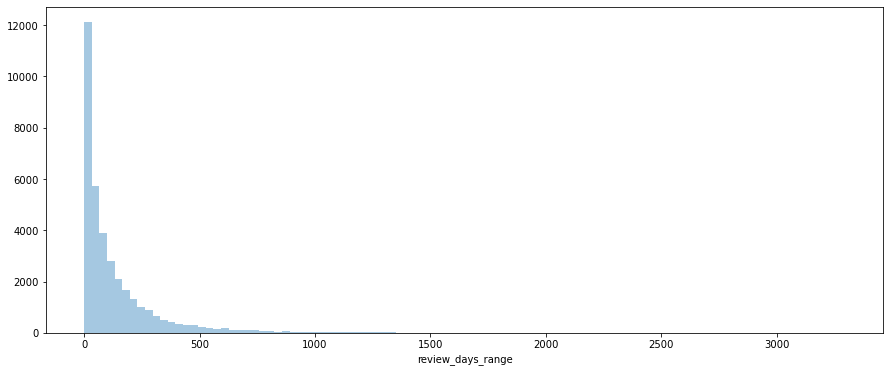

In [74]:
# Посмотрим распределение
draw_hist(repository.data, 'review_days_range', size=(15, 6))

Гистограмма сильно смещены вправо. После 1000 практически выравнивается.

In [75]:
# Попробуем взять 1500, далее каждую сотню количество уменьшается на 30 и менее.
len(repository.data.query('review_days_range > 1500'))

133

In [76]:
repository.data['review_days_range'] = repository.data['review_days_range'].apply(
    lambda x: 1500 if x > 1500 else x
)

In [77]:
# Заполним пропуски средней
mean = int(repository.data['review_days_range'].mean())

repository.data['review_days_range'].fillna(mean, inplace=True)

### Review days untill now [review_days_untill_now]

На сколько давно были оставлены последние отзывы

In [78]:
repository.data['review_days_untill_now'] = repository.data['review_dates'].apply(
    lambda x: pd.NaT if len(x) == 0 else (CURRENT_DATE - x.max()).days
)

In [79]:
repository.data['review_days_untill_now'].fillna((CURRENT_DATE - pd.to_datetime('01/01/1970')).days, inplace=True)

In [80]:
# Посмотрим на IQS границы
get_statistical_borders(repository.data, 'review_days_untill_now')

(462.0, 2814.0)

In [81]:
len(repository.data.query('review_days_untill_now > 1801'))

14264

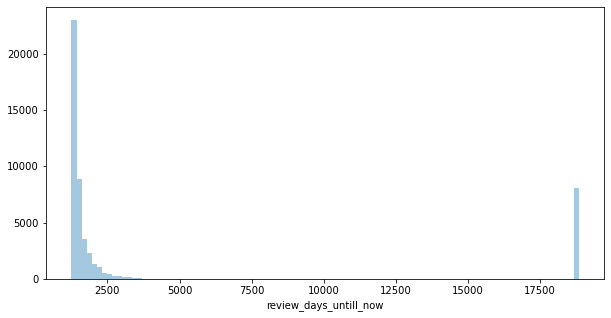

In [82]:
draw_hist(repository.data, 'review_days_untill_now', size=(10, 5))

Есть большое смещение в право.  После 3500 кривая выравнивается.

In [83]:
len(repository.data.query('review_days_untill_now > 3500'))

8257

In [84]:
# Выровним данные
repository.data['review_days_untill_now'] = repository.data['review_days_untill_now'].apply(
    lambda x: 3500 if x > 3500 else x
)

In [85]:
# Заполним пустые значения средней
mean = int(repository.data['review_days_untill_now'].mean())

repository.data['review_days_untill_now'].fillna(mean, inplace=True)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

## Распределение признаков

### Ranking [ranking]

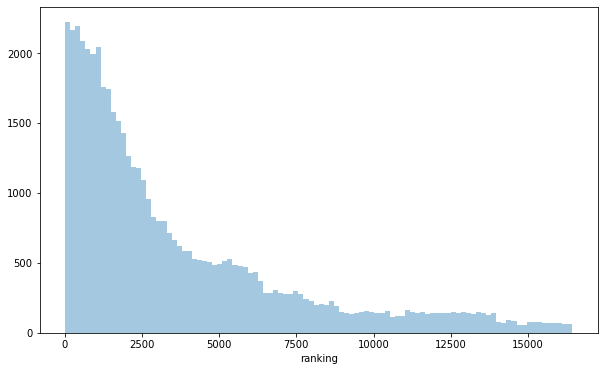

In [86]:
draw_hist(repository.data, 'ranking', size=(10, 6))

<AxesSubplot:>

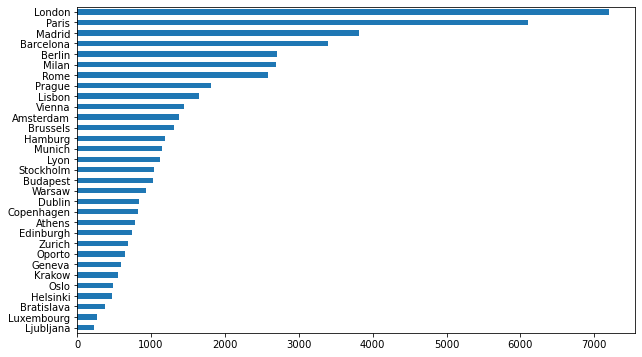

In [87]:
repository.data['city'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе:

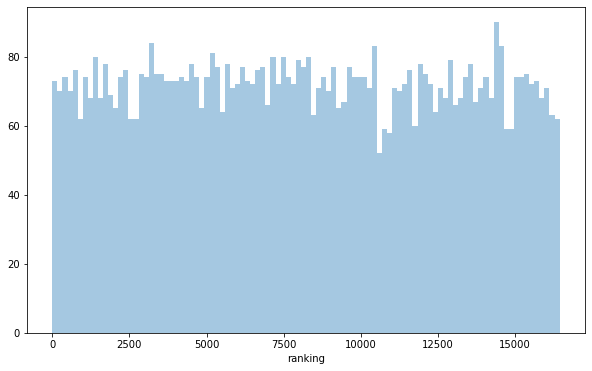

In [88]:
draw_hist(repository.data[repository.data['city'] =='London'], 'ranking', size=(10, 6))

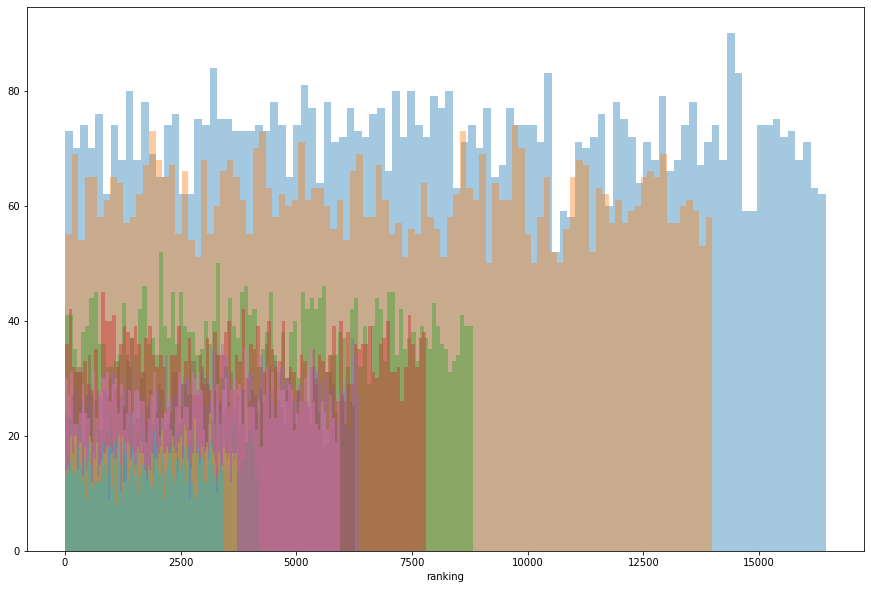

In [89]:
# посмотрим на топ 10 городов
for x in (repository.df_train['city'].value_counts())[0:10].index:
    draw_hist(repository.data[repository.data['city'] == x], 'ranking', size=(15, 10))
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за этого мы имеем смещение.


Для того, чтобы убрать смещение по городам, нормальлизуем таблицу **ranking** по городу в блоке нормализации.

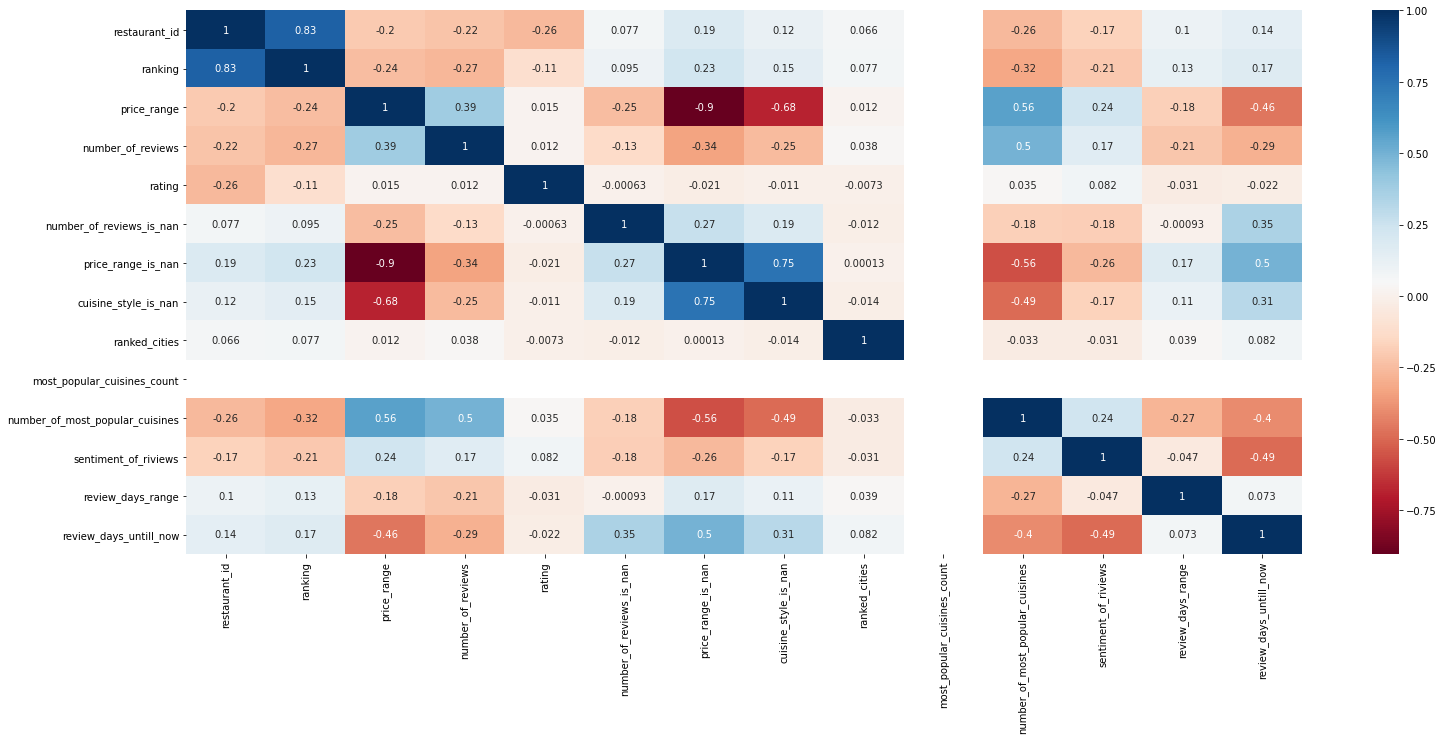

In [90]:
# Посмотрим тепловую карту
draw_heatmap(repository.data.drop(['sample'], axis=1), size=(25, 10))

## Добавление новых признаков

- Мы список **городов** по которым мы можем найти информацию из открытых источноков.
    - Столица город или нет
    - Покупательная способность населения в городе
    - Популяция
    - А так же количество ресторанов в городе (эта информация у нас уже есть, осталось только посчитать)
- Провести анализ отзывов
    - Положительные отзывы или отрицательные. Раз уж у нас есть только два отзыва, можно сделать из них dummy переменные.

### Является ли город столицей [capital]

In [91]:
capitals = set([
    'Oslo', 'Copenhagen', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon', 'Vienna', 
    'Amsterdam', 'Brussels', 'Stockholm', 'Budapest', 'Warsaw', 'London', 'Ljubljana',
    'CopenhagenEdinburgh', 'Athens', 'Paris', 'Dublin', 'Helsinki', 'Bratislava',
    'Luxembourg'
])

In [92]:
repository.data['capital'] = repository.data['city'].apply(
    lambda x: 1 if x in capitals else 0
).astype('uint8')

### Популяция в городе [population]

Информация взята из Wikipedia

In [93]:
population_dict = {
    'Amsterdam': 872680,
    'Athens': 664046,
    'Barcelona': 1620343,
    'Berlin': 3769495,
    'Bratislava': 437726,
    'Brussels': 1208542,
    'Budapest': 1752286,
    'Copenhagen': 794128,
    'Dublin': 554554,
    'Edinburgh': 488050,
    'Geneva': 201818,
    'Hamburg': 1845229,
    'Helsinki': 656229,
    'Krakow': 779115,
    'Lisbon': 505526,
    'Ljubljana': 295504,
    'London': 8909081,
    'Luxembourg': 626108,
    'Lyon': 516092,
    'Madrid': 3223334,
    'Milan': 1399860,
    'Munich': 1484226,
    'Oporto': 287591,
    'Oslo': 697549,
    'Paris': 2148271,
    'Prague': 1324277,
    'Rome': 2860009,
    'Stockholm': 975904,
    'Vienna': 2600000,
    'Warsaw': 1793579,
    'Zurich': 415215
}

In [94]:
repository.data['population'] = repository.data['city'].map(population_dict)

### Количество ресторанов в городе [city_rest_number]

In [95]:
city_rest_number_dict = dict(repository.data['city'].value_counts())

In [96]:
repository.data['city_rest_number'] = repository.data['city'].map(city_rest_number_dict)

### Покупательная способность [purchasing_power]

Индекс покупательской способности согласно рейтингу Numbeo (2018)

In [97]:
purchasing_power_dict = {
    'Amsterdam': 19,
    'Athens': 53,
    'Barcelona': 30,
    'Berlin': 8,
    'Bratislava': 39,
    'Brussels': 15,
    'Budapest': 51,
    'Copenhagen': 10,
    'Dublin': 27,
    'Edinburgh': 16,
    'Geneva': 3,
    'Hamburg': 7,
    'Helsinki': 9,
    'Krakow': 36,
    'Lisbon': 48,
    'Ljubljana': 32,
    'London': 24,
    'Luxembourg': 4,
    'Lyon': 70,
    'Madrid': 23,
    'Milan': 40,
    'Munich': 6,
    'Oporto': 42,
    'Oslo': 17,
    'Paris': 22,
    'Prague': 31,
    'Rome': 37,
    'Stockholm': 13,
    'Vienna': 21,
    'Warsaw': 29,
    'Zurich': 2
}

In [98]:
repository.data['purchasing_power'] = repository.data['city'].map(purchasing_power_dict)

### Туристическая привлекательность [tourist_attract]

Добавим признак туристическая привлекательность.
Место города в рейтинге топ-100 городов посещения в 2018 году
Источник - Euromonitor international

Так как не все города входят в топ-100, то города делим на группы:
- 1 = 1-25
- 2 = 26-50
- 3 = 51-75
- 4 = 76-100
- 5 = выше 100

In [99]:
tourist_attract_dict = {
    'Amsterdam': 1,
    'Athens': 2,
    'Barcelona': 2,
    'Berlin': 2,
    'Bratislava': 5,
    'Brussels': 3,
    'Budapest': 3,
    'Copenhagen': 3,
    'Dublin': 5,
    'Edinburgh': 5,
    'Geneva': 5,
    'Hamburg': 5,
    'Helsinki': 5,
    'Krakow': 3,
    'Lisbon': 3,
    'Ljubljana': 5,
    'London': 1,
    'Luxembourg': 5,
    'Lyon': 5,
    'Madrid': 2,
    'Milan': 5,
    'Munich': 3,
    'Oporto': 4,
    'Oslo': 5,
    'Paris': 1,
    'Prague': 1,
    'Rome': 1,
    'Stockholm': 4,
    'Vienna': 2,
    'Warsaw': 3,
    'Zurich': 5
}


In [100]:
repository.data['tourist_attract'] = repository.data['city'].map(tourist_attract_dict)

### Отношение количества отзывов к населению [reviews_per_city_population]

In [101]:
repository.data['reviews_per_city_population'] = repository.data['number_of_reviews'] / repository.data['population']

### Среднее количество отзывов в городе [mean_reviews_per_city]

In [102]:
mean_reviews_per_city = repository.data.groupby('city')['number_of_reviews'].mean()
mean_reviews_per_city = mean_reviews_per_city.apply(lambda x: round(x, 2))

repository.data['mean_reviews_per_city'] = repository.data['city'].map(mean_reviews_per_city)

### Количество кухонь в ресторане [number_of_cuisines]

In [103]:
repository.data['number_of_cuisines'] = repository.data['cuisine_style'].apply(lambda x: len(x))

### Количество редких кухонь в ресторане [cuisine_rare]

<AxesSubplot:>

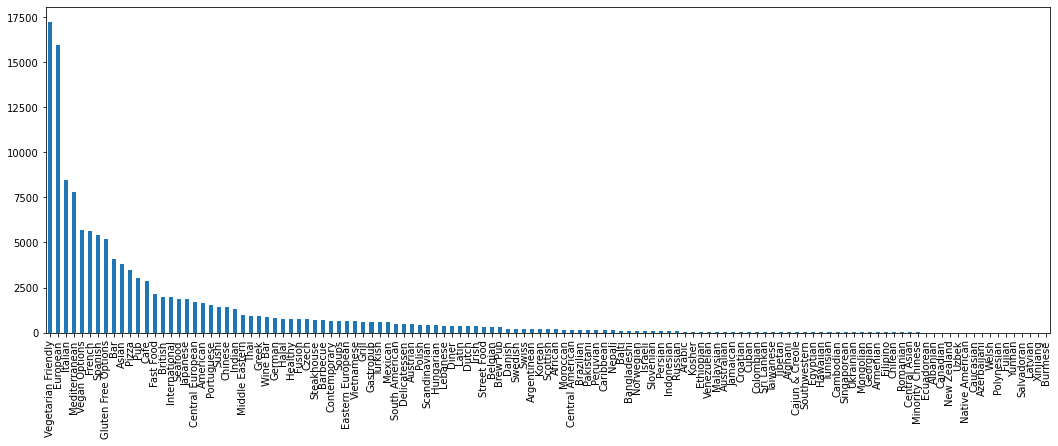

In [104]:
plt.figure(figsize=(18,6))
repository.data.explode('cuisine_style')['cuisine_style'].value_counts(ascending=False).plot(kind='bar')

vegetarian friendly и european лидируют. Кухни, встречающиеся меньше 50 раз, будем считать редкими.

In [105]:
cuisine_rare_set = set(repository.data.explode('cuisine_style')['cuisine_style'].value_counts()[
    repository.data.explode('cuisine_style')['cuisine_style'].value_counts() < 50
].index)

In [106]:
def cuisine_rare_count(cell):
    x = 0
    for i in cuisine_rare_set:
        if i in cell:
            x += 1
    return x

In [107]:
repository.data['cuisine_rare'] = repository.data['cuisine_style'].apply(cuisine_rare_count)

### Отношение ранга к количеству отзывов в городе

<AxesSubplot:xlabel='city'>

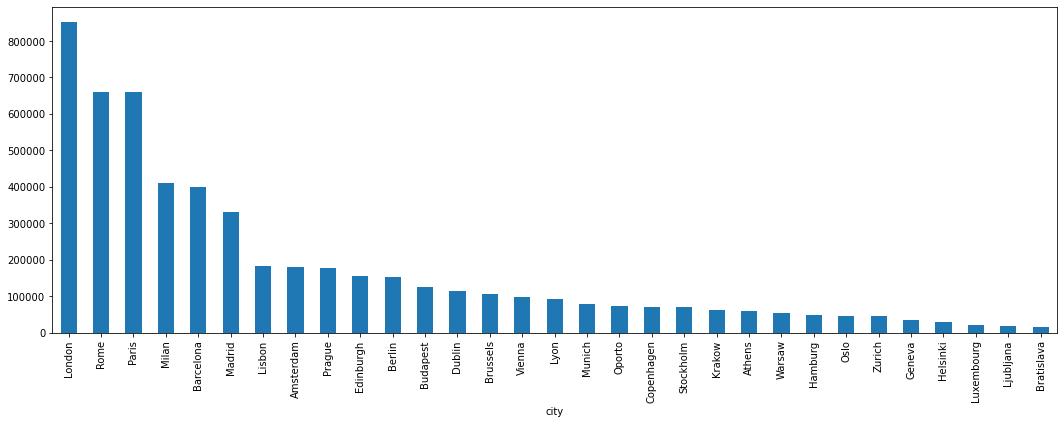

In [108]:
plt.figure(figsize=(18,6))
repository.data.groupby('city')['number_of_reviews'].sum().sort_values(ascending=False).plot(kind='bar')

In [109]:
rewiews_city_dict = dict(repository.data.groupby('city')['number_of_reviews'].sum())

In [110]:
repository.data['num_rewiews_city'] = repository.data['city'].map(rewiews_city_dict)

In [111]:
# Создадим признак отношения рейтинга в городе к количеству отзывов в городе.
repository.data['relative_rank_reviews'] = repository.data['ranking'] / repository.data['num_rewiews_city']

### Вычисляем к-во ресторанов на 1000 чел для города в каждой строке [restaurant_for_population]

In [112]:
repository.data['restaurant_for_population'] = repository.data['city_rest_number'] / repository.data['population']

### Отношение кол-ва ресторанов в городе к полуляции города и все это умноженное на ranking по городу [city_population_ranking]

In [113]:
repository.data['city_population_ranking'] = (repository.data['city_rest_number'] / repository.data['population']) * (repository.data['ranking'] / repository.data['city_rest_number'])

## Нормализуем числовые данные

Нормализуем как min-max все числовые данные там где число больше 1.

In [114]:
# Нормализация `ranking` по городам.
min_max_normalization_for_ranking_in_cities(repository.data)

In [115]:
# Нормализация `review_days_untill_now`
repository.data['review_days_untill_now'] = get_min_max_normalization(repository.data, 'review_days_untill_now')

In [116]:
# Нормализация `review_days_range`
repository.data['review_days_range'] = get_min_max_normalization(repository.data, 'review_days_range')

In [117]:
# Нормализация `number_of_reviews`
repository.data['number_of_reviews'] = get_min_max_normalization(repository.data, 'number_of_reviews')

In [118]:
# Нормализация `price_range`
repository.data['price_range'] = get_min_max_normalization(repository.data, 'price_range')

In [119]:
# Нормализация `population`
repository.data['population'] = get_min_max_normalization(repository.data, 'population')

In [120]:
# Нормализация `city_rest_number`
repository.data['city_rest_number'] = get_min_max_normalization(repository.data, 'city_rest_number')

In [121]:
# Нормализация `purchasing_power`
repository.data['purchasing_power'] = get_min_max_normalization(repository.data, 'purchasing_power')

In [122]:
# Нормализация `tourist_attract`
repository.data['tourist_attract'] = get_min_max_normalization(repository.data, 'tourist_attract')

In [123]:
# Нормализация `reviews_per_city_population`
repository.data['reviews_per_city_population'] = get_min_max_normalization(
    repository.data,
    'reviews_per_city_population'
)

In [124]:
# Нормализация `mean_reviews_per_city`
repository.data['mean_reviews_per_city'] = get_min_max_normalization(
    repository.data,
    'mean_reviews_per_city'
)

In [125]:
# Нормализация `number_of_cuisines`
repository.data['number_of_cuisines'] = get_min_max_normalization(repository.data, 'number_of_cuisines')

In [126]:
# Нормализация `number_of_most_popular_cuisines`
repository.data['number_of_most_popular_cuisines'] = get_min_max_normalization(
    repository.data,
    'number_of_most_popular_cuisines'
)

In [127]:
# Нормализация `relative_rank_reviews`
repository.data['relative_rank_reviews'] = get_min_max_normalization(
    repository.data,
    'relative_rank_reviews'
)

In [128]:
# Нормализация `num_rewiews_city`
repository.data['num_rewiews_city'] = get_min_max_normalization(repository.data, 'num_rewiews_city')

In [129]:
# Нормализация `relative_rank_reviews`
repository.data['relative_rank_reviews'] = get_min_max_normalization(repository.data, 'relative_rank_reviews')

In [130]:
# Нормализация `ranked_cities`
repository.data['ranked_cities'] = get_min_max_normalization(repository.data, 'ranked_cities')

In [131]:
# Нормализация `restaurant_for_population`
repository.data['restaurant_for_population'] = get_min_max_normalization(repository.data, 'restaurant_for_population')

In [132]:
# Нормализация `city_population_ranking`
repository.data['city_population_ranking'] = get_min_max_normalization(repository.data, 'city_population_ranking')

### Ранг ресторана по количеству отзывов [ranking_rev_count]

In [133]:
repository.data['ranking_rev_count'] = repository.data['ranking_by_city'] * repository.data['number_of_reviews']

In [134]:
# Нормализация `ranking_rev_count`
repository.data['ranking_rev_count'] = get_min_max_normalization(repository.data, 'ranking_rev_count')

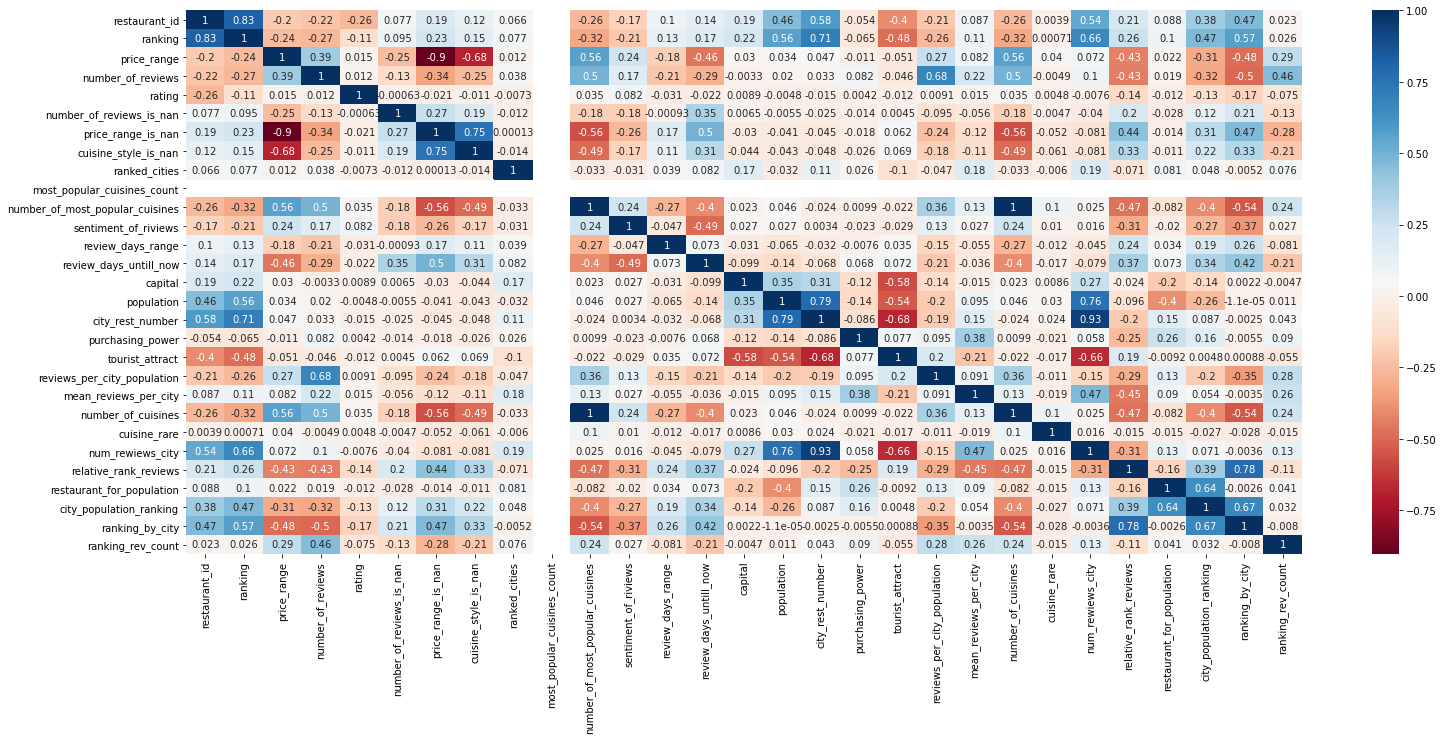

In [135]:
# Посмотрим тепловую карту
draw_heatmap(repository.data.drop(['sample'], axis=1), size=(25, 10))

## Создадим dummy переменные

Ранее было принято решение создать dummy переменные из столбцов `city` и `cuisine_style`.

In [136]:
# Преведем названия городов к нижнему регистру и заменим пробелы на нижнее подчеркивание
repository.data['city'] = repository.data['city'].apply(normalize_name)
# Приведем `city` к dummy переменным
repository.update_data(get_dummies(repository.data, 'city', 'data'))

In [137]:
# # Ухудшает результат
# # Поиск самых популярных кухонь
# cuisines = get_most_common_cuisines(repository.data)

# # Создаем dummy переменные для cuisine_style
# process_cuisine_style(repository.data, set(map(lambda x: x[0], cuisines)))

## Удалим лишние признаки

In [158]:
# Удаляем лишние признаки, а так же те, которые эксперементально показали ухудшение результата
prepared_data = repository.data.drop(columns=[
    'restaurant_id',
    'cuisine_style',
    'ranking',
    'reviews',
    'url_ta',
    'id_ta',
    'review_dates',
    'capital',
    'most_popular_cuisine_in_city'
])

## Оптимизация данных

Прогоним данные через селектор признаков, удаляющий все признаки с низкой дисперсией

In [159]:
from sklearn.feature_selection import VarianceThreshold

In [160]:
# Посмотрим начальный shape датасета
prepared_data.shape

(50000, 59)

In [161]:
# Прогоним данные через селектор
# selector = VarianceThreshold(threshold=0)

# selector.fit_transform(prepared_data)
# prepared_data = prepared_data[prepared_data.columns[selector.get_support(indices=True)]]

# prepared_data.shape

Нам удалось удалить один признак, очень хорошо!

# Data Preprocessing

In [162]:
# Теперь выделим тестовую часть
train_data = prepared_data.query('sample == 1').drop(['sample'], axis=1)
test_data = prepared_data.query('sample == 0').drop(['sample'], axis=1)

y = train_data['rating'].values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [163]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [164]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 58), (40000, 58), (40000, 57), (32000, 57), (8000, 57))

# Model 
Сам ML

In [165]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [166]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


In [149]:
y_pred = round_of_rating(y_pred)
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1650625


<AxesSubplot:>

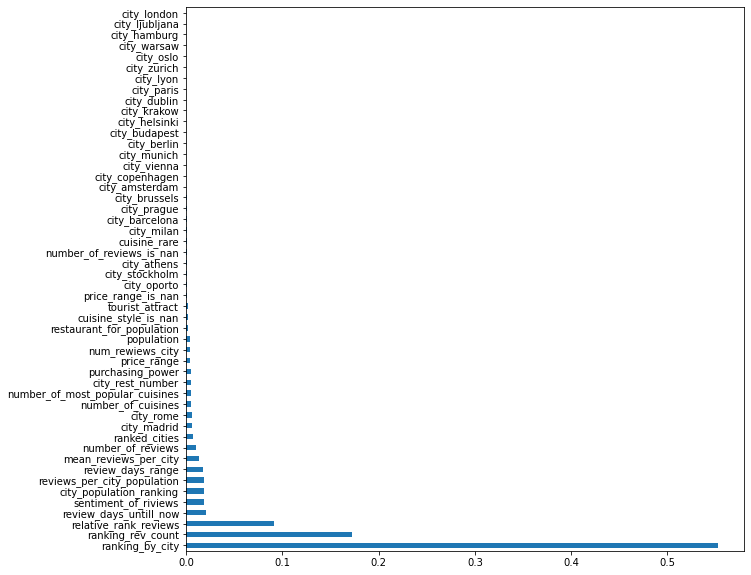

In [150]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')


# Submission
Если все устраевает - готовим Submission на кагл

In [151]:
test_data.sample(10)

,price_range,number_of_reviews,rating,number_of_reviews_is_nan,price_range_is_nan,cuisine_style_is_nan,ranked_cities,number_of_most_popular_cuisines,sentiment_of_riviews,review_days_range,review_days_untill_now,population,city_rest_number,purchasing_power,tourist_attract,reviews_per_city_population,mean_reviews_per_city,number_of_cuisines,cuisine_rare,num_rewiews_city,relative_rank_reviews,restaurant_for_population,city_population_ranking,ranking_by_city,ranking_rev_count,city_amsterdam,city_athens,city_barcelona,city_berlin,city_bratislava,city_brussels,city_budapest,city_copenhagen,city_dublin,city_edinburgh,city_geneva,city_hamburg,city_helsinki,city_krakow,city_lisbon,city_ljubljana,city_london,city_luxembourg,city_lyon,city_madrid,city_milan,city_munich,city_oporto,city_oslo,city_paris,city_prague,city_rome,city_stockholm,city_vienna,city_warsaw,city_zurich
1867,0.333333,0.003077,0.0,0,0,0,0.674117,0.05,-0.100000,0.093333,1.000000,0.147280,0.132406,0.058824,0.50,0.000418,0.129154,0.05,0,0.074979,0.290482,0.123819,0.119842,0.472826,0.001577,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3819,0.333333,0.011538,0.0,0,0,0,0.310487,0.05,0.406250,0.000000,0.033378,0.066301,0.047626,0.500000,0.50,0.002989,0.335156,0.05,0,0.055957,0.106233,0.102542,0.066494,0.305712,0.003823,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3896,0.000000,0.007692,0.0,0,1,0,0.771244,0.00,0.378125,0.397333,0.605696,0.223544,0.844355,0.294118,0.00,0.000723,0.314495,0.00,0,0.769561,0.263424,0.853846,0.633396,0.715297,0.005963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3126,0.666667,0.112308,0.0,0,0,0,0.310487,0.15,0.450000,0.072000,0.150423,0.066301,0.047626,0.500000,0.50,0.029092,0.335156,0.15,0,0.055957,0.110416,0.102542,0.069112,0.317780,0.038680,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7368,1.000000,0.495385,0.0,0,0,0,0.427749,0.10,0.350000,0.001333,0.025367,1.000000,1.000000,0.323529,0.00,0.011222,0.363670,0.10,0,1.000000,0.051260,0.136481,0.038409,0.153013,0.082152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7268,0.666667,0.027692,0.0,0,0,0,0.021931,0.05,0.072222,0.104667,0.020917,0.053085,0.079472,0.750000,0.25,0.008416,0.172393,0.05,0,0.053450,0.193055,0.263761,0.137005,0.373318,0.011204,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9030,1.000000,0.030769,0.0,0,0,0,0.897124,0.25,0.678571,0.008667,0.089453,0.305284,0.339550,0.514706,0.00,0.002171,1.000000,0.25,0,0.769654,0.105108,0.170965,0.189869,0.671263,0.022385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
903,0.000000,0.007692,0.0,0,1,1,0.771244,0.00,0.537500,0.032000,0.101914,0.223544,0.844355,0.294118,0.00,0.000723,0.314495,0.00,0,0.769561,0.278960,0.853846,0.670748,0.757491,0.006315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5071,0.000000,0.003077,0.0,0,1,0,0.283022,0.00,-0.100000,0.093333,1.000000,0.188740,0.138287,0.073529,1.00,0.000337,0.002898,0.00,0,0.040005,0.385144,0.078467,0.079957,0.396199,0.001321,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9950,0.000000,0.007692,0.0,0,1,1,0.771244,0.00,-0.100000,0.093333,1.000000,0.223544,0.844355,0.294118,0.00,0.000723,0.314495,0.00,0,0.769561,0.181718,0.853846,0.436947,0.493385,0.004113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [152]:
test_data = test_data.drop(['rating'], axis=1)

In [153]:
repository.sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [154]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [155]:
predict_submission = round_of_rating(predict_submission)

In [156]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [157]:
repository.sample_submission['Rating'] = predict_submission
repository.sample_submission.to_csv('submission.csv', index=False)
repository.sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
